# Love in the Time of Correlation
## Statistical Significance on *The Good Place*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup #For web scraping
import time # To delay scraping 
import requests

import copy #To deep-copy dict of script strings
import random

#For hypothesis testing:
from scipy import stats #To find t and p values with ttests

<a id = "top"></a>

# Contents

[Web Scraping](#webscraping)

["Attempt Log"](#attemptlog)

[Points to get in](#pointstogetin)

## Custom functions

In [2]:
def get_season_urls(season_path):
    #Complete URL for the page with the links to the scripts for the season
    season_page = url_head + season_path
    page = requests.get(season_page)
    soup = BeautifulSoup(page.content, 'html.parser')
    urls_raw = soup.findAll('a', class_ = 'season-episode-title')

    eps = []
    
    #Add tuples to eps list for each url ending and its episode number
    for i, url_raw in enumerate(urls_raw):
        path = url_raw.get('href')
        s = int(url_raw.get('href')[-5:-3])
        ep = int(url_raw.get('href')[-2:])
        eps.append((path, s, ep))
    
    #Build a DataFrame from the list of tuples
    season_urls = pd.DataFrame(eps, columns = ['url', 'season', 'episode'])
    
    return season_urls

In [3]:
#Scrape a web page for a script
#Return it as a string
def get_script(script_path):
    #Complete URL for the page with the script
    script_page = url_head + script_path
    page = requests.get(script_page)
    soup = BeautifulSoup(page.content, 'html.parser')
    raw_script = soup.find('div', class_ = 'scrolling-script-container')
    
    return str(raw_script)

In [4]:
#helper function for clean()
def remove_linebreak(script):
    script = script.replace('\r', ' ')
    if '  ' in script:
        script = remove_whitespace(script)
    return script

In [5]:
#helper function for clean()
def remove_whitespace(script): 
    while '  ' in script:
        script = script.replace('  ', ' ')
    if '\r' in script:
        remove_linebreak(script)
    else:
        return script

In [6]:
#Removes white space and line breaks,
#splits the text into a list of lines of dialogue,
#with each line numbered.
#Returns a list of tuples.
def clean(raw_script):
    #Call remove_linebreak and remove_whitespace recursively until 
    #all line breaks and whitespaces are removed.
    cleaned_script = remove_linebreak(raw_script)
    #Split the script into a list of lines of dialogue.
    split_script = cleaned_script.split('<br/>')
    tupled_script = []
    #Turn the lines into tuples to record the numbering.
    for i, line in enumerate(split_script):
        tupled_script.append((i, line))
    return tupled_script

In [7]:
#Find and return lines of dialogue with digits in them
#Captures numerals with commas like "125,000."
#Split the line into individual characters 
#and return True if a numeral is found.
def has_numbers(line):    
    letters = list(line)
    for letter in letters:
        if letter.isdigit():
            return True

In [8]:
#Returns dict with all all topical lines from the given scripts
def find_lines(topics, scripts):
    
    #Build new dict of episodes with only the topical lines of dialogue
    scripts_with_topical_lines = {}
    #Step 1: Iterate over each script in the dict
    for key, val in scripts.items():
        #Add the key for a given script to the new dict with an
        #empty list as its value.
        scripts_with_topical_lines[key] = []
        #Step 2: For each script, iterate over each line
        for i, line in val:
            #Step 3: Look for topical words by calling is_topical() on the line
            if is_topical(topics, line):
                #Step 4: Add the tuple of the line to the list for 
                #that script in the new dict of scripts.
                scripts_with_topical_lines[key].append((i, line))
    
    return scripts_with_topical_lines

In [9]:
#helper function for find_lines
#Find and return only topical lines
def is_topical(topics, line):
    #Look for topical words
    if any(topic in line for topic in topics):
            return True

In [10]:
#Print all the the lines from a given set of scripts
def print_lines(lines):
    for key, val in lines.items():
        if val:
            print(key)
            for line in val:
                print(line)
            print('\n')

In [11]:
#to append to the beginning of URL scraped from website
url_head = 'https://www.springfieldspringfield.co.uk/'

<a id = "webscraping"></a>

[(Back to top)](#top)

## Web scraping to gather data

### Get URLs for all pages with scripts

In [12]:
#Gather the URLs for each script page, by season
s01_urls = get_season_urls('episode_scripts.php?tv-show=the-good-place-2016&season=1')
s02_urls = get_season_urls('episode_scripts.php?tv-show=the-good-place-2016&season=2')
s03_urls = get_season_urls('episode_scripts.php?tv-show=the-good-place-2016&season=3')

In [13]:
#Need to correct for some inaccuracies in the episode numbering on the website.

#Step 1: 
#Get s01e01, s2e01, and s03e01

s01e01 = s01_urls.iloc[[0]]
s02e01 = s02_urls.iloc[[0]]
s03e01 = s03_urls.iloc[[0]]

In [14]:
#Step 2:
#Correct episode number for season 1 episode 2
s01_urls.at[0, 'episode'] += 1

#Correct episode numbers for all of season 2 and 3
for i in range(len(s02_urls)):
    s02_urls.at[i, 'episode'] += 1

for i in range(len(s03_urls)):
    s03_urls.at[i, 'episode'] += 1

In [15]:
#Step 3:
#Append the rest of each season to the first episode
s01_urls = pd.concat([s01e01, s01_urls], axis = 0, ignore_index = True)

s02_urls = pd.concat([s02e01, s02_urls], axis = 0, ignore_index = True)

s03_urls = pd.concat([s03e01, s03_urls], axis = 0, ignore_index = True)

In [16]:
#Okay, now we can continue
#Combine into one dataframe with all urls for scripts
season_urls = pd.concat([s01_urls, 
                         s02_urls, 
                         s03_urls], 
                        axis = 0, ignore_index = True)

In [17]:
#Take a look at the df that we'll use to scrape scripts
#from 39 webpages
season_urls.head()

,url,season,episode
0,view_episode_scripts.php?tv-show=the-good-plac...,1,1
1,view_episode_scripts.php?tv-show=the-good-plac...,1,2
2,view_episode_scripts.php?tv-show=the-good-plac...,1,3
3,view_episode_scripts.php?tv-show=the-good-plac...,1,4
4,view_episode_scripts.php?tv-show=the-good-plac...,1,5


### Scrape script for each episode

In [18]:
#empty dict of raw script strings
raw_scripts = {}

In [19]:
#Iterate over rows of the DF as tuples
#Populate dict of raw scripts
#Includes a time lag so that the remote server
#doesn't get too many requests too fast.
for row in season_urls.itertuples(index = False):
    #Script key will be a tuple of (season, episode)
    script_key = (row.season, row.episode)
    #Get script by scraping site and append to dict
    raw_scripts[script_key] = get_script(row.url)
    #Wait before pinging server again
    time.sleep(1)

In [20]:
#Correct for duplication of certain scripts by splitting them
#Chop up s1e1 and s1e2; s1e12 and s1e13; s2e1 and s2e2; and s3e1 and s3e2
#Chop up s1e1 and s1e2    line 350 and 351  What's it gonna be? [knock at door] [thunder crashes] Oh, stomachache.
raw_scripts[(1,1)] = raw_scripts[(1,1)][:21547]
raw_scripts[(1,2)] = raw_scripts[(1,2)][21547:]
#Chop up s1e12 and s1e13   (326, ' You have 30 minutes.') 21387
raw_scripts[(1,12)] = raw_scripts[(1,12)][:21387]
raw_scripts[(1,13)] = raw_scripts[(1,13)][21387:]
#Chop up s2e1 and s2e2
raw_scripts[(2,1)] = raw_scripts[(2,1)][:24800]
raw_scripts[(2,2)] = raw_scripts[(2,2)][24800:]
#Chop up s3e1 and s3e2
raw_scripts[(3,1)] = raw_scripts[(3,1)][:22554]
raw_scripts[(3,2)] = raw_scripts[(3,2)][22554:]

In [21]:
#Now we can continue
#Make a new dict of scripts to clean up
scripts = copy.deepcopy(raw_scripts)

In [22]:
#Clean all scripts to turn each into a list of strings of dialogue
for key, val in scripts.items():
    scripts[key] = clean(val)

# Lines about the system

In [116]:
the_system = ['system']

In [117]:
system_lines = find_lines(the_system, scripts)

In [118]:
print_lines(system_lines)

(1, 1)
(64, ' [laughter] Anyway, when your time on Earth has ended, we calculate the total value of your life using our perfectly accurate measuring system.')
(83, " Again, it's an incredibly selective system.")
(94, ' Now, let me show you the, uh the video system here.')
(331, ' Well, then this system sucks.')


(1, 2)
(19, " See, that's the trouble with these perfect systems.")
(160, " We switched to a rotating system for choosing a designated driver, and it's your turn.")
(162, ' Full disclosure, I forgot we were doing this new system.')
(167, " Guess the only place I'll be driving is through the giant loophole in the system I accidentally discovered.")
(178, " Oh, Tahani, if I made one tiny mistake in my design, if there's a single glitch in the system, if even one blade of grass is angled a a fraction of a degree off [dog whimpers] The whole neighborhood is compromised.")


(1, 8)
(4, " Our system has never made a mistake before It's just not possible.")
(232, ' I just want to say

s01e01
(64, ' [laughter] Anyway, when your time on Earth has ended, we calculate the total value of your life using our perfectly accurate measuring system.')
(83, " Again, it's an incredibly selective system.")
(370, " See, that's the trouble with these perfect systems.")

s01e08
(4, " Our system has never made a mistake before It's just not possible.")

s01e10
(190, ' - Of course, the system did screw up by letting Fake Eleanor in.')
(195, " I mean, the system might be so screwed up at this point that maybe you don't belong to either Eleanor.")

s02e01
(180, " Now, normally, our omniscient system perfectly analyzes each person's profile, and then matches him or her with another person.")

s02e13
(3, " The premise of our system is that a person's score during her time on Earth is final and inarguable, but because of my accidental experiment, these four humans got better after they died.")
(15, " If I'm right, the system by which we judge humans the very method we use to deem them good or bad is so fundamentally flawed and unreasonable that hundreds of millions of people have been wrongly condemned to an eternity of torture.")
(85, ' Why should we have to go live alone in a boring void because of a messed-up system? - How is that justice? - Okay.')

s03e01
(366, " [TENSE MUSIC] - [COMPUTER BEEPS] - Aha! Someone just went down to Earth, and that gave me a back door into The Judge's system.")

s03e05
(164, " It's a perfect system.")

s03e010
(136, ' [whooshing] The system is flawless, and tampering is quite impossible.')

s03e12
(140, ' Shawn, I have reason to believe that humans might be, on average, better than the points system suggests they are.')

# Lines about Janet

In [119]:
janet = ['janet', 'robot', 'know everything about', 'knowledge', 'updat', 'database']

In [120]:
janet_lines = find_lines(janet, scripts)

In [121]:
print_lines(janet_lines)

(1, 1)
(161, " She's like this walking database.")


(1, 2)
(4, ' Hey, how do I make that helper woman show up? Hello? Front desk lady? Magical slave robot? Excuse me, Janet? - Hi there.')


(1, 6)
(124, ' [robotically] Does not compute.')


(1, 7)
(181, ' Each new update of Janet gains more wisdom and social abilities.')
(207, ' I am simply an anthropomorphized vessel of knowledge built to make your life easier.')
(210, ' Ugh, you want a robot killed right, you have to do it yourself.')
(272, " Uh, her memory must have been wiped clean, so now she's gonna have to re-upload all the knowledge in the universe, which will only take a few days.")
(336, ' I want to keep you all updated.')


(1, 10)
(288, '" - [gags] - "Jacksonville Jaguars rule!" Jason, when I was rebooted, and I lost all my knowledge, I was confused and disoriented, but you were always kind to me.')


(1, 11)
(113, ' As you know, each time I am updated, I accrue new knowledge and abilities.')


(1, 13)
(158, " Oh, that's e

s01e01
(161, " She's like this walking database.")

s01e07
(181, ' Each new update of Janet gains more wisdom and social abilities.')
(207, ' I am simply an anthropomorphized vessel of knowledge built to make your life easier.')
(272, " Uh, her memory must have been wiped clean, so now she's gonna have to re-upload all the knowledge in the universe, which will only take a few days.")

s01e09
(146, " I mean, it does matter if I know things, because I'm an informational delivery system, and I don't have a heart, but thanks.")

s01e10
(288, '" - [gags] - "Jacksonville Jaguars rule!" Jason, when I was rebooted, and I lost all my knowledge, I was confused and disoriented, but you were always kind to me.')


s01e11
(113, ' As you know, each time I am updated, I accrue new knowledge and abilities.')

s02e06
(75, ' I am simply a vessel containing all of the knowledge in the universe.')

s02e07
(191, ' Say what now? After the very first time you were rebooted, and as you were slowly regaining your knowledge, you bonded with Jason.')

(358, " You contain all the knowledge in the universe, you have a rippin' bod, and you can literally do anything.")

s02e10
(138, ' In case you were wondering, I am by definition the best version of myself, because my operating system is always updating.')

s02e12
(47, " Wait, you don't already know everything about us? You're not omniscient? Well Not in the way you mean.")

s03e03
(127, ' Ever since we walked through that portal, my knowledge has stopped updating.')

s03e06
(29, ' I do know everything about you and Simone and computer programming and virtual reality and artificial intelligence and the human brain and everything else.')

s03e13
(43, ' Janet is a walking database of all the knowledge in the universe, and since you, John, seem to like asking a relentless number of questions, go ahead.')

# Chidi and Eleanor fall in lovej

In [125]:

scripts[(3,8)]

[(0,
  '<div class="scrolling-script-container"> \n \n \n \t\t\t1 This library\'s depressing.'),
 (1, ' All they have in the Poetry section is Jeff Foxworthy books.'),
 (2,
  " Well, we needed someplace deserted, and there's no place more deserted than a public library in Arizona."),
 (3, " Now let's go, man."),
 (4,
  ' We only have a few hours before we have to pick the gang up from the airport.'),
 (5, " Fire up Janet's memory gizmo."),
 (6, ' Flooding your brain with memories from the afterlife is dangerous.'),
 (7, ' In one of the reboots, you and Chidi were in love.'),
 (8, " Can't you just take my word for that? No, dude, I can't."),
 (9,
  ' My screwed-up relationship with my parents made me believe I could never really love anyone.'),
 (10, ' I need to see it for myself.'),
 (11, ' Those are my memories.'),
 (12, ' I want them back.'),
 (13, ' Okay, fine.'),
 (14, ' Have a seat.'),
 (15,
  ' Luckily, before we shut the neighborhood down, Janet saved a complete record of all th

s02e04

(278,
  ' How many times in all the reboots did I ask Chidi for help, he refused to help me and then I had to get better on my own? Never.'),
 
 (279, ' He always helped you.'),
 
 (280, ' God.'),
 
 (281, ' - Really? - Yep.'),
 
 (282,
  " No matter how I set it up, you found him, confessed you didn't belong, asked him for help, and he said yes."),
 
 (283, ' Now his agreeing to help was part of my plan.'),
 
 (284, " What wasn't part of my plan was it actually working."),
 
 (285, ' Drove me nuts.'),
 
 (286, ' Pesky little nerd.'),
 
 (287, ' Stuck with you and always helped you overcome your biggest problem.')

s03e07
 
 (337,
  ' In one of the reboots, you and Chidi fell in love deeply, and you told him that you loved him, and he told you that he loved you back.')#Mihael tells Eleanor about falling in love with Chidi in reboot 119

s03e08

(34, ' So now I can show you the highlights of reboot 119.')

(184,
  " Oh, yeah? We know this is, like, the hundredth time you've tried to torture us, but this time it's different, because we're in love."),

(185, ' And love is stronger than anything you can throw at us.'),

(191,
  " No matter what he does, we will find each other, and we will help each other, because we're soul mates."),

(216,
 ' I put you and Chidi in close proximity, because I needed you to drive each other crazy.'),

(217, ' But I never intended for you to fall in love.'),

In [30]:
scripts[(2,4)]

[(0,
  '<div class="scrolling-script-container"> \n \n \n \t\t\t1 We\'re on the same page.'),
 (1, ' I wanna team up with you guys.'),
 (2,
  " What? Why? You do? What? I'm in a bit of a bind and I could use some backup."),
 (3,
  " So, what do you say? New best friends? You wanna team up? You've been torturing us - and lying about it."),
 (4,
  " - Let's not get all caught up on who lied to who or which one of us created an entire fake reality in order to cause eternal misery for the others."),
 (5, " That's ancient history."),
 (6, ' It was happening until 20 seconds ago.'),
 (7, ' The point is that circumstances have changed.'),
 (8, ' And now, all of us teaming up is our best option.'),
 (9, ' I love being on teams.'),
 (10, ' Oh, we need a team name.'),
 (11, ' Um the Bobcats.'),
 (12, ' - Great.'),
 (13, ' - Slow down, ding dong.'),
 (14, " He wouldn't offer us a deal for no reason."),
 (15, ' He needs us.'),
 (16, ' - Why? - Because, as you said, you keep beating me.'),
 (17,
  

# Lines about numbers

In [41]:
#empty dict for episodes with lists of lines of 
#dialogue containing numbers
number_lines_from_scripts = {}

In [42]:
number_words = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', ' ten ',
           'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen',
           'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety',
            'hundred', 'thousand', 'million', 'billion', 'trilion',
            'first', 'second', 'third', 'fifth', 'ninth']

In [43]:
#Redundant to find_lines() for now.
#Build new dict of episodes with only the lines of dialogue
#containing number words.
#Step 1: Iterate first over each script in the dict
for key, val in scripts.items():
    #Add the key from scripts to the new dict
    number_lines_from_scripts[key] = []
    #Step 2: For each script, iterate over each line
    for i, line in val:
        #Step 3: Look for number words
        if is_topical(number_words, line):
            #Step 4: Add the line to the list of lines for 
            #that script in the new dict.
            number_lines_from_scripts[key].append((i, line))
        #If the line doesn't have spelled-out number words,
        #check for digits. Add the line when the first digit
        #is found.
        elif has_numbers(line):
            number_lines_from_scripts[key].append((i, line))

In [52]:
scripts[(3,10)]

[(0,
  '<div class="scrolling-script-container"> \n \n \n \t\t\t1 [soft beep] Wow! Ho-ho! Oh, Janet, you did it! You brought us into your void.'),
 (1, ' If I had a heart, it would be pounding.'),
 (2,
  " - Michael - You know, you'd think there'd be side effects, but I feel great."),
 (3,
  " How's the hair? Is it still amazing? Michael, there may have been some side effects for the humans."),
 (4, ' Huh.'),
 (5,
  ' Dude, why are there so many Janets? Anwhy do I sound like Janet? You also look like Janet.'),
 (6,
  ' Do I? Why? What? What is happening? [groans] Oh, no, am I wearing a vest? Ooh, Michael, help me! This is going to be tricky.'),
 (7, " How do we even tell them apart? Oh! [laughs] Okay, that one's Jason."),
 (8,
  " [bright music] I can't put the humans back in their own bodies, so I've done the next best, but still not that great, thing."),
 (9,
  " A high-neck sleeveless? - I suppose this outfit will do? - [sarcastically] Are you sure? I mean, wearing a floral print to

In [ ]:
how_many_points = find_lines(['need'])

## "Points" lines

In [47]:
points = [' points', ' earn', ' lose', 'lost', 'losing']

In [48]:
points_lines = find_lines(points, number_lines_from_scripts)

In [49]:
print_lines(points_lines)

(1, 6)
(0, '<div class="scrolling-script-container"> \n \n \n \t\t\t1 [upbeat music] - What are you doing? - [gasps] Dude, I\'m freaked out about my meeting with Michael, and if I spend one more second staring at Creepo the Clown, I\'m gonna lose it.')


(1, 8)
(184, ' [door opens] You guys, what is happening? Someone egged my Lexus, and I have like 40,000 tweets calling me the "Dress Bitch"? Over a loser dry cleaner man? Why is everyone so jealous of me? This is a trash city full of idiots.')


(1, 11)
(13, ' - [beep] - You just lost five points.')
(18, " - Look, I know this is tedious, but holding a door for someone is three points, and if you do it for everyone in the neighborhood, then that's almost a thousand points for just a start.")
(141, ' [beep] Hey, your score just went up 20 points.')


(2, 2)
(183, " - Homey, no! I'm not spending another second with this loser.")


(2, 6)
(96, " But I know for a fact that if you steal a loaf of bread, it's a negative 17 points 20 if it's a

s01e11
(9, ' Now, the average point total for a resident here is roughly 1.2 million.')
 
 
 s3e10
 (165,
  " Can you just tell me his total so far? Looks like he's at 520,000 points."),
 (166, ' - Well done, Doug.'),
 (167, " - So that's that's good? Oh, it's excellent."),
 (168, " Wait, he's 68 years old? Oh, that's terrible."),
 (169, " He's screwed."),

## "Attempts" lines

In [49]:
attempts = ['attempt', 'try', 'tries', 'tried', 'version', 'experiment', 'time']

In [50]:
attempt_lines = find_lines(attempts, number_lines_from_scripts)

In [51]:
print_lines(attempt_lines)

s01e01
(386, ' That was my first time as a fashion "don\'t," and I did not care for it.')


s01e04
(267, " But first, I'd like to try something fun.")
(363, " I read this entire David Hume book, and then I read it again because I didn't understand it the first time, and now I'm ready to go.")
(373, ' I just have two questions: when are football tryouts? And does this school have a prom? Oh, no.')
(375, " For the first time ever, I'm the smartest kid in class.")


s01e05
(190, " Yeah, I noticed! You know what, man? I have spent every second in this place worried I was gonna get caught, but if we go down right now, that's on you, okay? Oh, you spend all your time teaching a charming, awesome lady? How sad for you.")


s01e06
(204, ' And do you like France as much as I do? Well, they enslaved my country for 300 years.')


s01e07
(64, '" Could you describe it? It\'s the color of [sighs] When a soldier comes home from war and sees his dog for the first time.')
(299, " - What? I told you tha

## All "time" lines

In [52]:
time = ['second', 'minute', 'day', 'week', 'month', 'year']

In [54]:
time_lines = find_lines(time, number_lines_from_scripts)

In [55]:
print_lines(time_lines)

s01e01
(57, ' - And welcome to your first day in the afterlife.')
(76, " You know the way you feel when you see a picture of two otters holding hands? That's how you're gonna feel every day.")
(148, ' I was the top salesperson five years running.')
(217, ' Do you have a second to talk about the environment? Do you have a second to eat my farts? You missed.')
(233, '" And I know we just met on this bus ten minutes ago, but he seemed nice.')
(238, ' I had been an apprentice for over 200 years, and my boss has finally given me my first solo project.')
(435, ' Welcome to orientation, day two.')
(559, ' But in my defense, there were only five minutes left in flying and I wanted to go flying.')


s01e03
(43, ' Yes, I spent 18 years working on my manuscript called "Who We Are and Who We Are Not colon "Practical Ethics and Their Application in the Modern World semi-colon a Treatise" Yes, yes, yes, that\'s the one.')
(212, ' This took me two weeks to get through.')


s01e04
(70, " [laughing] I 

### All "topical" dialogue from which to get parameters

In [ ]:
topics = ['point', 'points', 'second', 'seconds',  'minute',
              'minutes', 'day', 'days', 'week', 'weeks', 
              'month', 'months', 'year', 'years', 'time', 'times',
             'people', 'humans', 'attempt', 'attempts',
              'try', 'tries', 'version', 'versions']

In [ ]:
all_topical = find_lines(topics, number_lines_from_scripts)

In [41]:
print_lines(all_topical)

s01e01
(42, ' Each one contains exactly 322 people who have been perfectly selected to blend together into a blissful harmonic balance.')
(57, ' - And welcome to your first day in the afterlife.')
(76, " You know the way you feel when you see a picture of two otters holding hands? That's how you're gonna feel every day.")
(148, ' I was the top salesperson five years running.')
(175, " [people yelling and screaming, mechanical buzzing] - The bear has two mouths! - [people screaming] [sound stops] Well, it doesn't sound awesome.")
(217, ' Do you have a second to talk about the environment? Do you have a second to eat my farts? You missed.')
(233, '" And I know we just met on this bus ten minutes ago, but he seemed nice.')
(238, ' I had been an apprentice for over 200 years, and my boss has finally given me my first solo project.')
(386, ' That was my first time as a fashion "don\'t," and I did not care for it.')
(435, ' Welcome to orientation, day two.')
(457, " Whoo! [woman laughing] - 

<a id = "attemptlog"></a>

[(Back to top)](#top)

# "Attempt log"

In [470]:
random.seed(11)

#How long it took Eleanor to figure out she wasn't in The Good Place
#max: 11 months  at 770th attempt
max_ = 334
max_index = (771)

#min: 8 seconds at 556th attempt
min_ = 8 / 86400
min_index = (557)

#total attempts: 802
pop_size = 802

#This distribution gets pretty close. 
#Use 800 random values with a max of 9 months.
attempts = np.random.randint(low = 10, high = 270, size = pop_size - 2)

#manually add an 11-second value and an 11-month value.
attempts = np.insert(attempts, min_index, min_)
attempts = np.insert(attempts, max_index, max_)

#All attempts together should add up to around 300 years
attempts.sum() / 365

309.23835616438356

<BarContainer object of 802 artists>

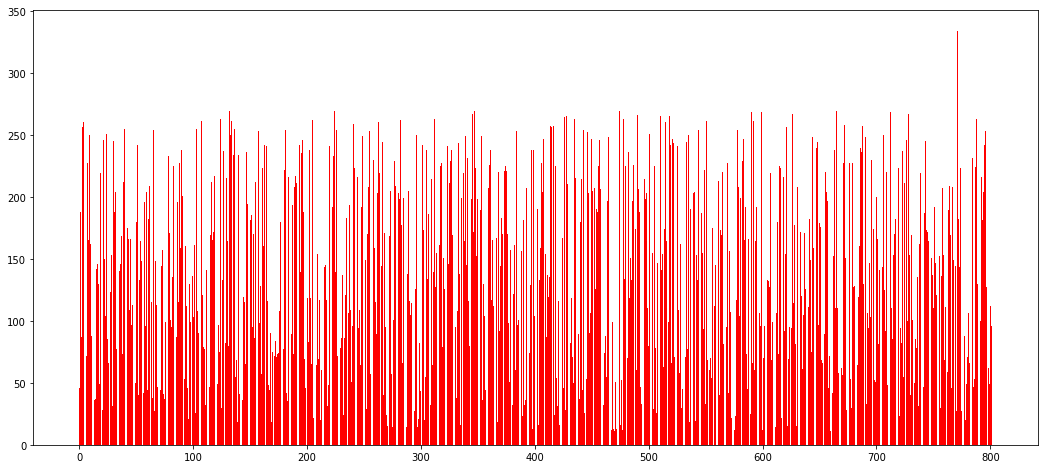

In [471]:
#plot attempts as bar graph
fig = plt.figure(figsize = (18,8))
plt.bar(range(pop_size), attempts, color = 'red')

(array([ 1.,  0., 10., 16.,  9., 18.,  7.,  7., 13., 14.,  8., 13.,  9.,
         6., 10., 12., 11., 13., 11., 13., 15., 15., 15., 17.,  7., 10.,
        12.,  9., 17., 20., 14., 18., 10., 19., 20., 17., 15., 10., 12.,
        12., 15., 11., 10.,  9., 12., 14., 13., 19., 14., 10., 16., 14.,
        10., 11., 12., 19., 11., 12., 15., 14., 10., 11., 18., 12.,  4.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.]),
 array([  0.   ,   4.175,   8.35 ,  12.525,  16.7  ,  20.875,  25.05 ,
         29.225,  33.4  ,  37.575,  41.75 ,  45.925,  50.1  ,  54.275,
         58.45 ,  62.625,  66.8  ,  70.975,  75.15 ,  79.325,  83.5  ,
         87.675,  91.85 ,  96.025, 100.2  , 104.375, 108.55 , 112.725,
        116.9  , 121.075, 125.25 , 129.425, 133.6  , 137.775, 141.95 ,
        146.125, 150.3  , 154.475, 158.65 , 162.825, 167.   , 171.175,
        175.35 , 179.525, 183.7  , 187.875, 192.05 , 196.225, 200.4  ,
        204.575, 208.75 , 212.925, 217.1  , 2

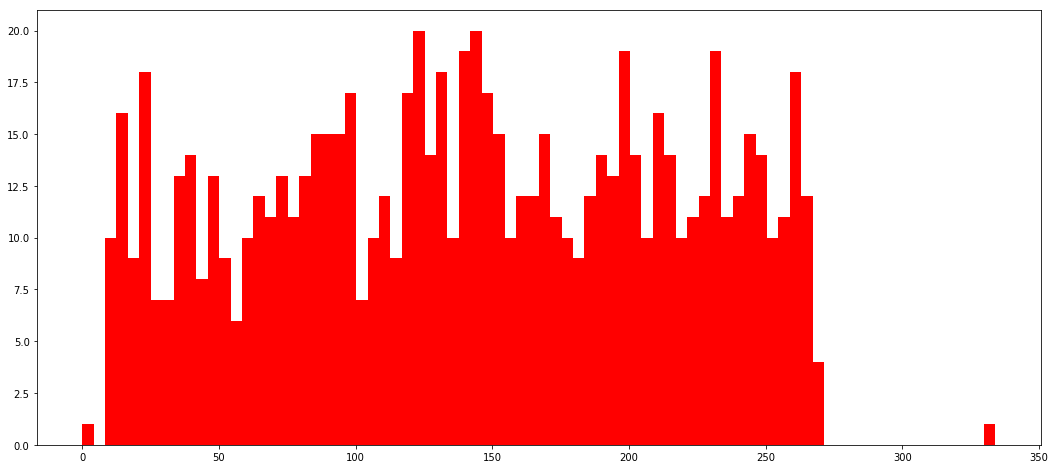

In [453]:
fig = plt.figure(figsize = (18,8))
plt.hist(attempts, bins = 80, color = 'red')

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


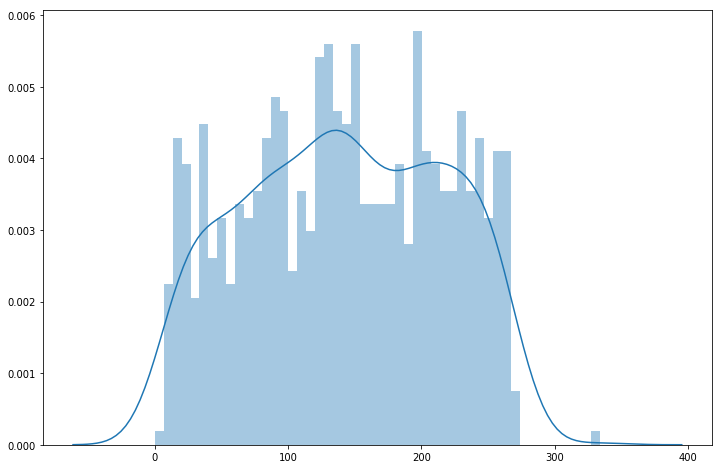

In [457]:
#plot attempts
fig = plt.figure(figsize = (12, 8))
sns.distplot(attempts, bins = 50)

## Hypothesis 1: Length of experiment

     s01e12
     (562, Michael: 'I think that we can get them to torture each other for 1,000 years.')
     (563, Sean: 'I think you'll be lucky to get six months out of this insane gambit.')



In [459]:
alpha = 0.05
seans_mean = (31 * 3) + (30 * 2) + 28 #181 days
michaels_mean = 365 * 1000 #1000 years

In [467]:
#Test Sean's mean
test_statistic, pvalue = stats.ttest_1samp(attempts, seans_mean)
print('Test statistic:', test_statistic)
print('P value:', pvalue)
print('Sean\'s mean:', seans_mean)
print('Sample mean:', attempts.mean())

Test statistic: -14.850679941463795
P value: 3.0096293345151445e-44
Sean's mean: 181
Sample mean: 142.31795511221947


In [469]:
#Test Michael's mean
test_statistic, pvalue = stats.ttest_1samp(attempts, michaels_mean)
print('Test statistic:', test_statistic)
print('P value:', pvalue)
print('Michael\'s mean:', michaels_mean)
print('Sample mean:', attempts.mean())

Test statistic: -140074.92819865452
P value: 0.0
Michael's mean: 365000
Sample mean: 142.31795511221947


<a id = 'pointstogetin'></a>

[(Back to top)](#top)

# Points to get in

520000 at 68 years old is "terrible"; "he's screwed"

Lady from video in Michael's first fake neighborhood: 999276

Figures for Michael's first fake neighborhood:

Average for resident: 1222821

Low: 997485

High: 2987309

2707234

2655118

2635744

2588673